# Example: Working with raster data

In [1]:
import hydromt

data_catalog = hydromt.DataCatalog(data_libs=["artifact_data=v1.0.0"])

Here, we illustrate some common GIS problems and how the functionality of the DataArray/Dataset [raster](../api/gis.rst#raster-methods) accessor can be used. The data is accessed using the HydroMT [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst). For more information see the [Reading raster data](reading_raster_data.ipynb) example.

Note that this implementation is based on a very earlier version of [rioxarray](https://corteva.github.io/rioxarray/stable/) and in fact we are using some of rioxarray functionality and working towards replacing our duplicated functionality with that of rioxarray and will try to contribute new functionality to rioxarray. The original reason for the raster data accessor was that we needed some changes in the internals of the writing methods for PCRaster data which is not fully supported by its GDAL driver. Currently the key difference between both packages, besides the naming of the accessor and some methods, are in new methods that have been added over time by both packages and the way that the raster attribute data is stored. In HydroMT this attribute data is always stored in the `spatial_ref` coordinate of the DataArray/Dataset whereas rioxarray uses additional attributes of the RasterDataset class. 

## Geospatial attributes 

Using the `raster` accessor we can get (and set) many geospatial properties of regular raster datasets. 

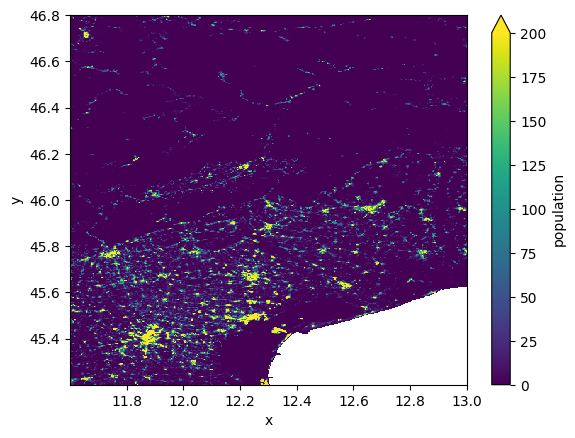

In [2]:
# get the GHS population raster dataset from the catalog
da = data_catalog.get_rasterdataset("ghs_pop_2015").rename("population")
da.raster.mask_nodata().reset_coords(drop=True).plot(vmax=200)

In [3]:
# coordinate reference system
da.raster.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# geospatial transform, see https://www.perrygeo.com/python-affine-transforms.html
da.raster.transform

Affine(np.float64(0.0024999999900981278), np.float64(0.0), np.float64(11.600416643117885),
       np.float64(0.0), np.float64(-0.0024999999899385983), np.float64(46.80041668121458))

In [5]:
# names of x- and y dimensions
(da.raster.x_dim, da.raster.y_dim)

('x', 'y')

In [6]:
# nodata value (or fillvalue) of a specific variable
da.raster.nodata

np.float64(-200.0)

## Reproject (warp) raster data

A common preprocessing step to generate model data is to make sure all data is in the same CRS. The [.raster.reproject()](reading_raster_data.ipynb) are build on **rasterio** and **GDAL** and make this really easy for you. 

In this example we demonstrate how to reproject a population count grid. This grid should not be reprojected directly to other resolutions in order to conserve the total number of people. Therefore, we first derive the population density using [.raster.density_grid()](../_generated/hydromt.gis.DataArray.raster.density_grid.rst) which can be reprojected and combined with the project grid cell area using [.raster.area_grid()](../_generated/hydromt.gis.DataArray.raster.area_grid.rst) to calculate the final population count. Using this approach we only make a small error which we correct to preserve the total count. 

Destination CRS: EPSG:32633
Error: 0.036%


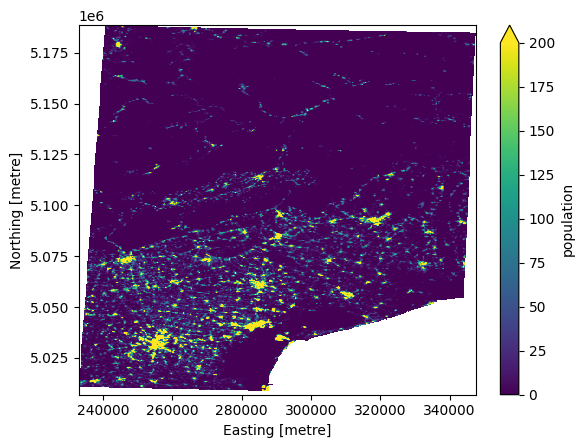

In [7]:
from hydromt.gis import utm_crs

utm = utm_crs(da.raster.bounds)
print(f"Destination CRS: {utm}")
da_pop = da.raster.mask_nodata()
da_pop_dens = da_pop.raster.density_grid().rename("population_dens")  # pop.m-2
da_pop_dens_utm = da_pop_dens.raster.reproject(
    method="bilinear", dst_crs=utm, dst_res=250
)
da_pop_utm = da_pop_dens_utm * da_pop_dens_utm.raster.area_grid()  # pop
bias = (da_pop.sum() / da_pop_utm.sum()).compute().item()
print(f"Error: {(1-bias)*100:.3f}%")
da_pop_utm_adj = da_pop_utm * bias  # bias correct
da_pop_utm_adj.name = "population"
da_pop_utm_adj.reset_coords(drop=True).plot(vmax=200)

## Zonal statistics

For many vector models, zonal statistics are required to derive model parameters. The [.raster.zonal_stats()](../_generated/hydromt.gis.DataArray.raster.zonal_stats.rst) method implements a range of statistics, but also allows for user defined statistics passed as a callable. Here we provide an example to get the population count per admin 3 level. HydroMT takes care that the vector data is reprojected to the raster data CRS if necessary.

In [8]:
import numpy as np
import xarray as xr

gdf = data_catalog.get_geodataframe("gadm_level3", variables=["NAME_3"])
ds = xr.merge(
    [
        da_pop.raster.zonal_stats(gdf, stats=["sum"]) / 1e3,  # count [pop x1000]
        da_pop_dens.raster.zonal_stats(gdf, stats=["max", np.nanmax])
        * 1e6,  # density [pop km-2]
    ]
)
for var in ds.data_vars:
    gdf[var] = ds[var]

gdf.sort_values("population_sum", ascending=False).head()

object: PyogrioDriver does not use kwarg predicate with value intersects.


object: PyogrioDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category='geography' notes='last downloaded 2020-10-19; license required for commercial use' url='https://gadm.org/download_world.html' author='gadm' license='https://gadm.org/license.html'.


,NAME_3,geometry,population_sum,population_dens_max,population_dens_nanmax
339,Venezia,"MULTIPOLYGON (((12.17899 45.46872, 12.17908 45...",241.430775,19783.234302,19783.234302
186,Padova,"MULTIPOLYGON (((11.97606 45.40236, 11.97544 45...",204.654669,14919.109912,14919.109912
324,Treviso,"MULTIPOLYGON (((12.18336 45.66973, 12.18387 45...",81.099755,10378.027434,10378.027434
278,Pordenone,"MULTIPOLYGON (((12.62392 45.98614, 12.62745 46...",51.308482,11382.017847,11382.017847
232,Bassano Del Grappa,"MULTIPOLYGON (((11.68664 45.73788, 11.68658 45...",44.323634,8070.610833,8070.610833


<Axes: >

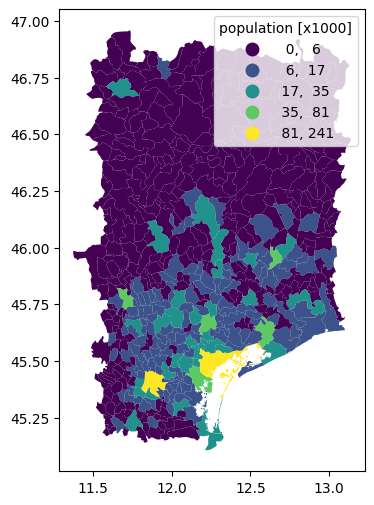

In [9]:
gdf.plot(
    "population_sum",
    scheme="NaturalBreaks",
    legend=True,
    legend_kwds=dict(fmt="{:.0f}", title="population [x1000]"),
    figsize=(6, 6),
)

## Interpolate nodata values

To create a continuos grid with values gaps in the data can be filled trough interpolation. HydroMT has the [.raster.interpolate_na()](../_generated/hydromt.gis.DataArray.raster.interpolate_na.rst) method with several interpolation options available. For the nearest, linear and cubic interpolation the [scipy.interpolate.griddata()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) method is used. First, a mesh of all valid values surrounding the data gaps is build using voronoi triangulation. Then, values are calculated for each grid cell with a nodata value. Note that nearest method also extrapolates, while the other methods only interpolate gaps. A final method is based on [rasterio.fill.fillnodata()](https://rasterio.readthedocs.io/en/latest/api/rasterio.fill.html) method.

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((13 45.6, 13 45.8, 12.7 45.8, 12.7 45....


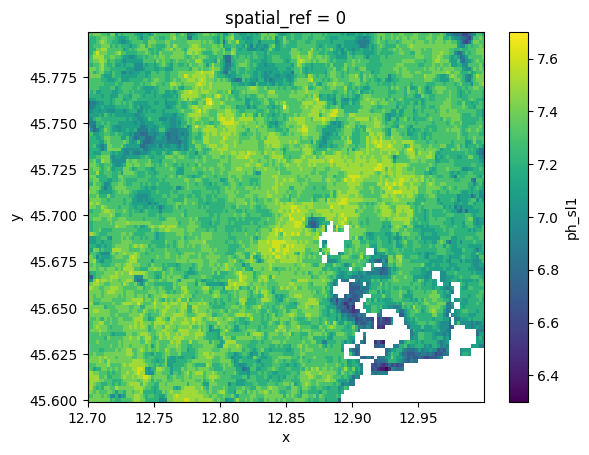

In [10]:
da_soil = data_catalog.get_rasterdataset(
    "soilgrids", bbox=[12.7, 45.6, 13, 45.8], variables=["ph_sl1"]
)
da_soil.raster.mask_nodata().plot()

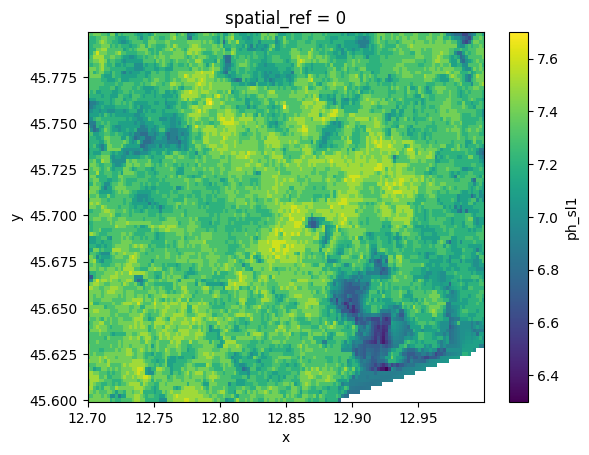

In [11]:
# Note that data is only interpolated leaving a small nodata gap in the lower right corner. This can be extrapolated with the 'nearest' method.
da_soil.raster.interpolate_na(method="linear").raster.mask_nodata().plot()

## Reproject and merge

This example shows how to use the [.raster.reproject_like()](../_generated/hydromt.gis.DataArray.raster.reproject_like.rst) method to align different datasets such that these are at identical grids and can be merged. 

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((13 45.3, 13 45.8, 12.2 45.8, 12.2 45....


resolution MERIT Hydro: 0.00083
resolution GEBCO: 0.00417
resolution MDT: 0.12500


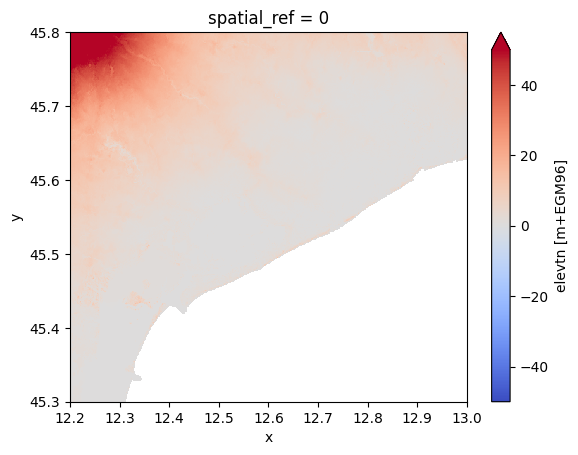

In [12]:
# step 1: read the data and mask nodata values
bbox = [12.2, 45.3, 13, 45.8]
da_dem = data_catalog.get_rasterdataset("merit_hydro", variables=["elevtn"], bbox=bbox)
da_dem = da_dem.raster.mask_nodata()
da_dem.attrs.update(units="m+EGM96")
print(f"resolution MERIT Hydro: {da_dem.raster.res[0]:.05f}")
da_bath = data_catalog.get_rasterdataset("gebco").raster.mask_nodata()
print(f"resolution GEBCO: {da_bath.raster.res[0]:.05f}")
da_mdt = data_catalog.get_rasterdataset("mdt_cnes_cls18").raster.mask_nodata()
print(f"resolution MDT: {da_mdt.raster.res[0]:.05f}")

plot_kwargs = dict(
    vmin=-50,
    vmax=50,
    cmap="coolwarm",
)
da_dem.plot(**plot_kwargs)

resolution reprojected GEBCO: 0.00083


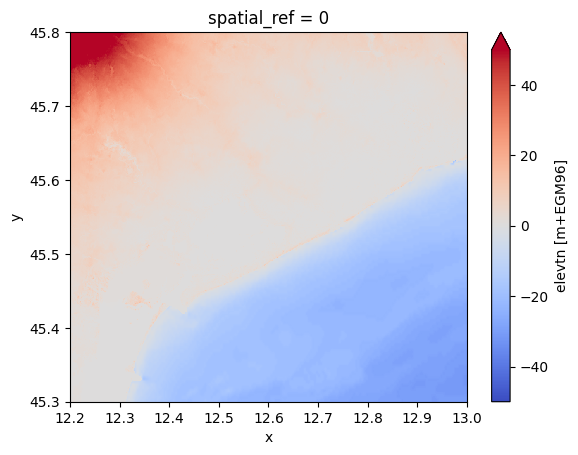

In [13]:
# step 2: convert GEBCO to EGM96 ref and reproject to MERIT Hydro grid
da_bath_egm = da_bath + da_mdt.raster.reproject_like(da_bath)
da_bath_reproj = da_bath_egm.raster.reproject_like(da_dem, method="cubic")
print(f"resolution reprojected GEBCO: {da_bath_reproj.raster.res[0]:.05f}")
da_dem_merged = da_dem.where(da_dem.notnull(), da_bath_reproj)
da_dem_merged.plot(**plot_kwargs)

## Write raster to file

To write a dataset to a raster file the [.raster.to_raster()](../_generated/hydromt.gis.DataArray.raster.to_raster.rst) can be used. By default the file is written in GeoTiff format. Each band is written as a layer of the raster file. A xarray.Dataset with multiple variables can be written to multiple files in a single folder, each with the name of the variable as basename with [.raster.to_mapstack()](../_generated/hydromt.gis.Dataset.raster.to_mapstack.rst). 

Here, we use the merged DEM output of the previous example to write to file. To ensure the CRS and nodata metadata are written we first update these attributes of the data based on the original DEM data.

In [14]:
da_dem_merged.raster.set_crs(da_dem.raster.crs)
da_dem_merged.raster.set_nodata(-9999)
da_dem_merged.raster.to_raster(
    "tmpdir/dem_merged.tif", tags={"history": "produced with HydroMT"}
)